<a href="https://colab.research.google.com/github/aka-gera/Data_Classification/blob/main/wine_quality_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WINE QUALITY PREDICTION**

---


We will use classification algorithms to predict a wine quality based on the various features provided in the dataset


---

This dataset is sourced from:  https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

---

The algorithms demonstrate an average accuracy level of up to 67%.

---

The most influential features contributing to the prediction are:

1. The amount of total sulfur dioxide in the wine
2. The amount of chlorides in the wine
3. The amount of residual sugar in the wine


These features significantly impact the classification process, contributing to the model's predictive accuracy.


##Dataset Description


Here is a brief description of the dataset.

| Column                | Description                                         |
|-----------------------|-----------------------------------------------------|
| fixed acidity         | The amount of fixed acids in the wine               |
| volatile acidity      | The amount of volatile acids in the wine            |
| citric acid           | The amount of citric acid in the wine               |
| residual sugar        | The amount of residual sugar in the wine            |
| chlorides             | The amount of chlorides in the wine                  |
| free sulfur dioxide   | The amount of free sulfur dioxide in the wine       |
| total sulfur dioxide  | The amount of total sulfur dioxide in the wine      |
| density               | The density of the wine                             |
| pH                    | The pH value of the wine                             |
| sulphates             | The amount of sulphates in the wine                 |
| alcohol               | The alcohol content of the wine                      |
| quality               | The quality score of the wine (0 to 10)             |
| Id                    | Identifier for each wine sample                      |


# Preset Parameters

In [105]:
data_dir =  f'yasserh/wine-quality-dataset'  # Dataset location

view_hist_feat = [0, 1, 2, -2, -1]  # Features selected for histogram visualization

target_switcher = 11  # Switch target to a feature which is in the last column

feat = [11]  # Features to drop

data_nan = 'mode'  # Fill NaN values:
                   #   Choose 'mode' to fill NaN values with the mode of the feature
                   #   Choose 'mean' to fill NaN values with the mean of the feature
                   #   Choose 'drop' to drop rows containing NaN values

balanced_dataset = False  # Whether to balance the dataset or not

target_str = -1   # Change target values into string

confidence_interval_limit = []  # Define the limits of the confidence interval [-m, m] and eliminate the outliers

correlation_percentage_threshold = 0.5  # Set the correlation threshold between features for removal

pre_proc = 'X'  # Data preprocessing:
                #   Choose 'XY' to standardize both 'X' and 'Y',
                #   Choose 'X' to standardize only 'X',
                #   Choose 'Y' to standardize only 'Y',

target_values_label = False  # True if target values are float or integers

####### Neural Network Parameters #######
activation = 'relu'
epoch = 10
num_nodes = [2, 4]
dropout_prob = [0.05, 0.1]
lr = [0.01, 0.1]
batch_size = [2, 4]


# Import Dataset

In [2]:
! pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd
%cd /content

/content
/content


In [5]:
! mkdir ~/.kaggle

In [6]:
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download {data_dir}

Dataset URL: https://www.kaggle.com/datasets/yasserh/wine-quality-dataset
License(s): CC0-1.0
  0% 0.00/21.5k [00:00<?, ?B/s]
100% 21.5k/21.5k [00:00<00:00, 27.8MB/s]


In [9]:
import os
file_names = os.listdir()
zip_file =   [file for file in file_names if file.endswith('.zip')]
zip_file

['wine-quality-dataset.zip']

In [10]:
import zipfile

# Open the zip file
with zipfile.ZipFile(zip_file[-1], 'r') as zip_ref:
    zip_ref.extractall()
    unzipped_file_names = zip_ref.namelist()
unzipped_file_names

['WineQT.csv']

# Import the helper classes

In [11]:
!pwd
%cd /content/drive/MyDrive/ML2023/data-analysis

/content
/content/drive/MyDrive/ML2023/data-analysis


In [12]:
!pip install AutoLogging-ML
!pip install xgboost
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.9 MB/s eta 0:00:00


In [13]:
! pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.0 MB/s eta 0:00:00


In [14]:
from plotly.subplots import make_subplots
from AutoLogging_ML import AutoLogger
import seaborn as sns

from aka_data_analysis.aka_plot import aka_plot, aka_correlation_analysis
from aka_data_analysis.aka_learning import aka_learn,aka_clean,aka_filter

aka_plot = aka_plot()
aka_corr_an = aka_correlation_analysis()
aka_clean = aka_clean()
aka_learn = aka_learn()
aka_filter = aka_filter()
aka_corr_an = aka_correlation_analysis()

In [15]:
from aka_data_analysis.aka_nn import aka_nn

In [16]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
import pandas as pd


# Dataset Information

In [122]:
df = aka_clean.df_get(f'/content/{unzipped_file_names[0]}')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [123]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [124]:
# view_hist_feat = [0,1,2,-2,-1]
fig = aka_plot.Plot_histogram_Features(df,view_hist_feat )
if fig is not None:
    fig.show()

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [126]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [127]:

df_f =df[df.columns[-2]]
df[df.columns[-2]] = df_f[df_f<5]=5
df[df.columns[-2]] = df_f[df_f>7]=7

# Null Values

In [128]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

In [129]:
aka_plot.plot_missing_values(df)

# Clean Dataset

## Drop Duplicate data

In [130]:
df.drop_duplicates()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


## Swap the target and the last feature

In [131]:
# target_switcher = -1
df = aka_clean.swap_features(df,target_switcher)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Id,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,4,5


### Drop feature(s)


In [132]:
# feat =  []
df = aka_clean.drop_feature(df,feat)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Convert target values into string

In [133]:
# target_str = -1
aka_clean.Replace_item_into_str_df(df,col=target_str)

##  Convert categorical variables into numerical representations

In [134]:
# data_nan = 'drop'  # Choose 'mode' to fill NaN values with the mode of the feature
#                    # Choose 'mean' to fill NaN values with the mean of the feature
#                    # Choose 'drop' to drop rows containing NaN values

mapping,swapMapping = aka_clean.CleaningVar(df)
df = aka_clean.CleaningDF(df,mapping,data_nan)

## Balance Dataset

In [135]:
aka_plot.plot_pie(df,-1)

In [136]:
# balanced_dataset = False

if balanced_dataset:
  df = aka_clean.balance_df(df,'j')
  aka_plot.plot_pie(df, -1)

## Correlation Matrix

In [137]:
aka_corr_an.Plot_Correlation_Matrix(df)

In [138]:

# confidence_interval_limit =   [-3,3]             # Define the limits m of the confidence interval [-m, m] and eliminate the outliers'''

# correlation_percentage_threshold = .7      # Set the limit of the correlation between the feature to be removed

df_filtered,corr_tmp = aka_learn.filter_drop_corr_df(df,confidence_interval_limit,correlation_percentage_threshold)

print(f'We dropped {df.shape[0]-df_filtered.shape[0]} outliers and remove {df.shape[1]-df_filtered.shape[1]} feature(s)')
print(f'The filtered dataset\'s shape is {df_filtered.shape} ')

We dropped 0 outliers and remove 5 feature(s)
The filtered dataset's shape is (1143, 7) 


## Graph the features that are highly correlated


In [139]:
fig = aka_corr_an.Plot_Correlate_Features(df,list(corr_tmp))
if fig is not None:
    fig.show()

### Visualize the distribution of the filtered dataset

In [140]:
aka_plot.Plot_box_Features(df,df_filtered,corr_tmp=range(df_filtered.shape[1]))

# Search for the most effective ML algorithm to learn the dataset

In [141]:
# pre_proc = 'X'                                # Choose between 'XY' to standardize both 'X' and 'Y',
#                                               #                'X' to standardize only 'X',
#                                               #                'Y' to standardize only 'Y',

X_train, X_test, y_train, y_test = aka_learn.Learning_data(df_filtered,pre_proc)

In [142]:
r,model =AutoLogger.train_and_log_classification(X_train,y_train,X_test,y_test,size='large')
y_pred = model.predict(X_test)

In [143]:
model

ExtraTreesClassifier()

<Axes: xlabel='validation-accuracy', ylabel='model'>

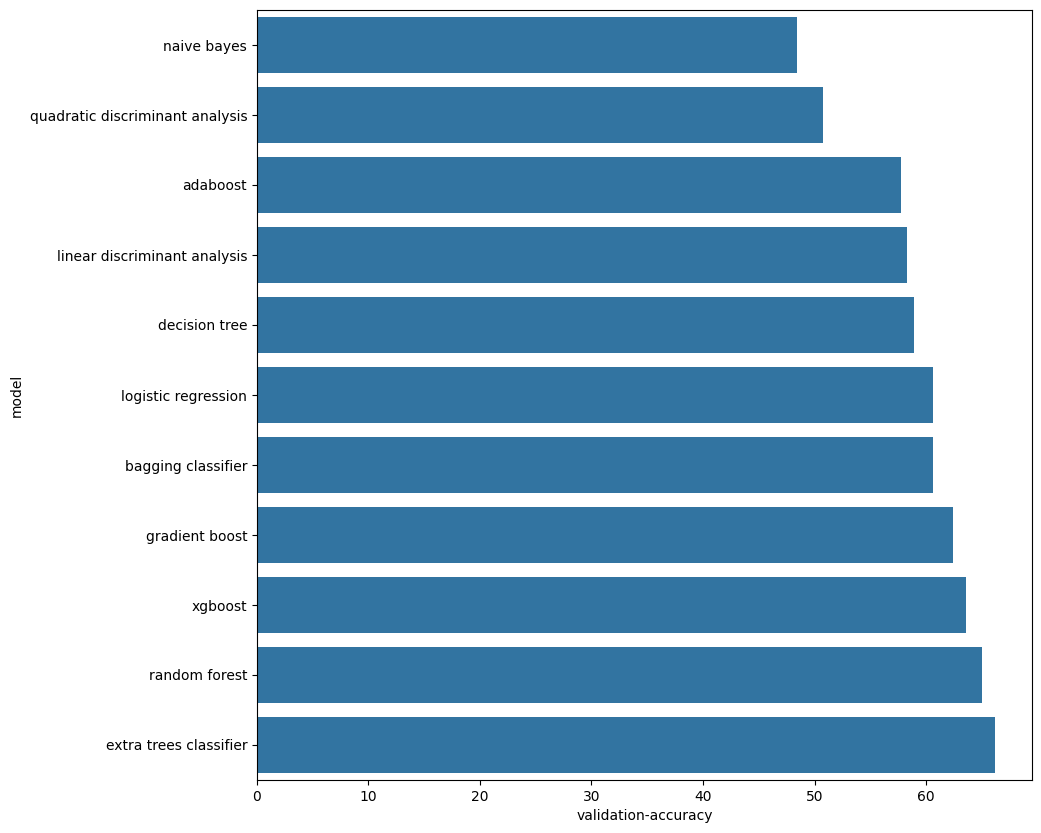

In [144]:
AutoLogger.get_metric_plot_classification(r,'validation','accuracy')


## Confusion Matrix

In [145]:
# target_values_label = True

y_pred_ = aka_clean.swap_map(y_pred,swapMapping)
y_test_ = aka_clean.swap_map(y_test,swapMapping)

if target_values_label:
  Label = [str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]
else:
  Label = ['v_'+str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]

In [146]:
Label

['v__5', 'v__6', 'v__7']

In [147]:
Label = ['x <= 5','x = 6','x >= 7']

In [148]:
fig2 =  aka_plot.plot_confusion_matrix(y_test_,y_pred_,Label)
fig2.show()

## Classification Report

In [149]:
fig3 =  aka_plot.plot_classification_report(y_test_,y_pred_,Label)
fig3.show()

## Plot Important Features by Weight



In [150]:
# aka_plot.plot_important_features(model,df_filtered)

 99%|===================| 2377/2400 [01:12<00:00]       

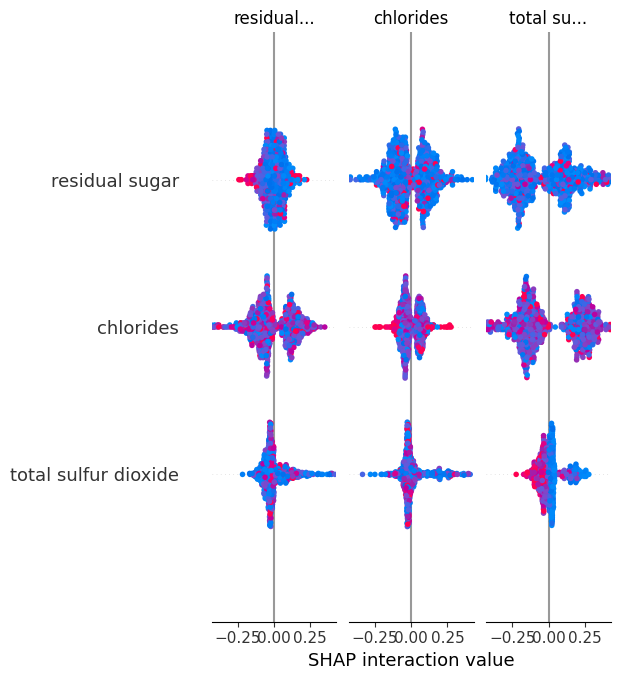

In [151]:
feat_names = df_filtered.columns[:-1]
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feat_names)

# Neural Net

In [152]:

myNN = aka_nn(X_train, X_test, y_train, y_test,activation)
model,scre =myNN.DNN(epoch,num_nodes,dropout_prob,lr,batch_size)
y_pred = myNN.predict(model)

2 nodes, dropout 0.05, lr 0.01, batch size 2
11/11 [==============================] - 0s 2ms/step - loss: 0.3656 - accuracy: 0.6122
2 nodes, dropout 0.05, lr 0.01, batch size 4
11/11 [==============================] - 0s 3ms/step - loss: 0.3756 - accuracy: 0.5918
2 nodes, dropout 0.05, lr 0.1, batch size 2
11/11 [==============================] - 0s 3ms/step - loss: 0.4772 - accuracy: 0.4257
2 nodes, dropout 0.05, lr 0.1, batch size 4
11/11 [==============================] - 0s 3ms/step - loss: 0.4927 - accuracy: 0.4257
2 nodes, dropout 0.1, lr 0.01, batch size 2
11/11 [==============================] - 0s 4ms/step - loss: 0.4255 - accuracy: 0.5831
2 nodes, dropout 0.1, lr 0.01, batch size 4
11/11 [==============================] - 0s 2ms/step - loss: 0.4767 - accuracy: 0.4257
2 nodes, dropout 0.1, lr 0.1, batch size 2
11/11 [==============================] - 0s 2ms/step - loss: 0.4862 - accuracy: 0.4257
2 nodes, dropout 0.1, lr 0.1, batch size 4
11/11 [==============================] 

## Confusion Matrix

In [153]:
y_pred_ = aka_clean.swap_map(y_pred,swapMapping)
y_test_ = aka_clean.swap_map(y_test,swapMapping)
# Label = [str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]

In [154]:
fig2 =  aka_plot.plot_confusion_matrix(y_test_,y_pred_,Label)
fig2.show()

## Classification Report

In [155]:
fig3 =  aka_plot.plot_classification_report(y_test_,y_pred_,Label)
fig3.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Plot Important Features by Weight


ExactExplainer explainer: 801it [00:19, 35.20it/s]


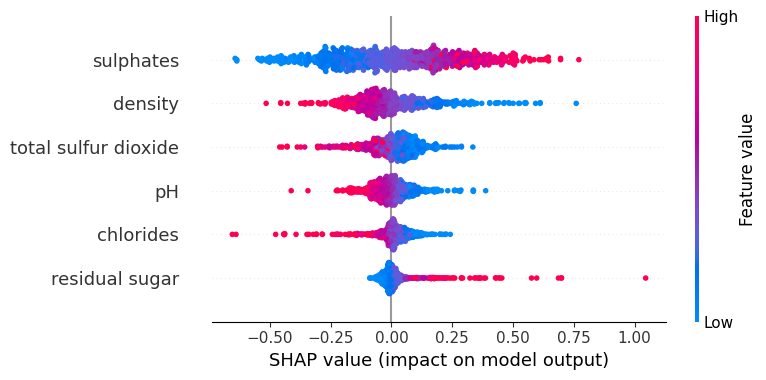

In [156]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feat_names)